In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymongo import MongoClient

# Configuração visual para ficar bonito no slide
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [ ]:
# 1. Conexao ao Banco
client = MongoClient("mongodb://localhost:27017/cognikidsDB")
db = client.get_default_database()
col_raw = db.iot_raw_data

print(f"Conectado ao Data Lake. Total de registros brutos: {col_raw.count_documents({})}")

# 2. Extracao (Pipeline)
# Trazemos 50.000 registros para a analise ser robusta
pipeline = [
    {
        "$project": {
            "bpm": "$dados_biometricos.bpm",
            "gsr": "$dados_biometricos.gsr",
            "movimento": "$dados_biometricos.movement_score", # Padronizamos como 'movimento'
            "aluno_id": "$aluno_id",
            "data": "$timestamp_sao_paulo"
        }
    },
    {"$limit": 50000}
]

print("Extraindo amostra de dados...")
dados = list(col_raw.aggregate(pipeline))
df = pd.DataFrame(dados)

print(f"OK: DataFrame pronto! Dimensoes: {df.shape}")
df.head()

🔌 Conectado ao Data Lake. Total de registros brutos: 13958
⏳ Extraindo amostra de dados...
✅ DataFrame pronto! Dimensões: (13958, 6)


,_id,bpm,gsr,movimento,aluno_id,data
0,6921ecb21baacc6dc2281408,99.769017,0.364377,0.801147,69111874ca4398a1897afba3,2025-09-23T14:03:42.264324-03:00
1,6921ecb21baacc6dc2281409,98.850230,0.676984,0.882757,69111874ca4398a1897afba4,2025-09-23T14:03:42.326324-03:00
2,6921ecb21baacc6dc228140a,65.811856,0.770191,0.792756,69111874ca4398a1897afba5,2025-09-23T14:03:42.377324-03:00
3,6921ecb21baacc6dc228140b,85.068285,0.546834,1.185043,69111874ca4398a1897afba6,2025-09-23T14:03:42.261324-03:00
4,6921ecb21baacc6dc228140c,106.569927,0.692159,1.032425,69111874ca4398a1897afba3,2025-09-23T14:04:42.332324-03:00


In [ ]:
# Funcao para classificar o estado fisiologico
def classificar_estado(row):
    bpm = row.get('bpm', 0)
    mov = row.get('movimento', 0)
    gsr = row.get('gsr', 0)
    
    # Regra Fisiologica: 
    # Crise se (Coracao Rapido E Parado) OU (Muito Suor)
    if (bpm > 120 and mov < 1.0) or (gsr > 2.5):
        return 1 # Crise
    return 0 # Normal

# Aplica a funcao
df['crise'] = df.apply(classificar_estado, axis=1)

print("OK: Coluna 'crise' criada com sucesso!")
# Mostra a proporcao para confirmar
print(df['crise'].value_counts(normalize=True))

✅ Coluna 'crise' criada com sucesso!
crise
0    0.84439
1    0.15561
Name: proportion, dtype: float64


### 2. Análise Fisiológica (Boxplots)
Aqui validamos a premissa biológica:
* **BPM:** Esperamos valores mais altos em crises.
* **GSR (Suor):** Deve ser significativamente maior nas crises (suor frio).
* **Movimento:** Ajuda a distinguir exercício de pânico.

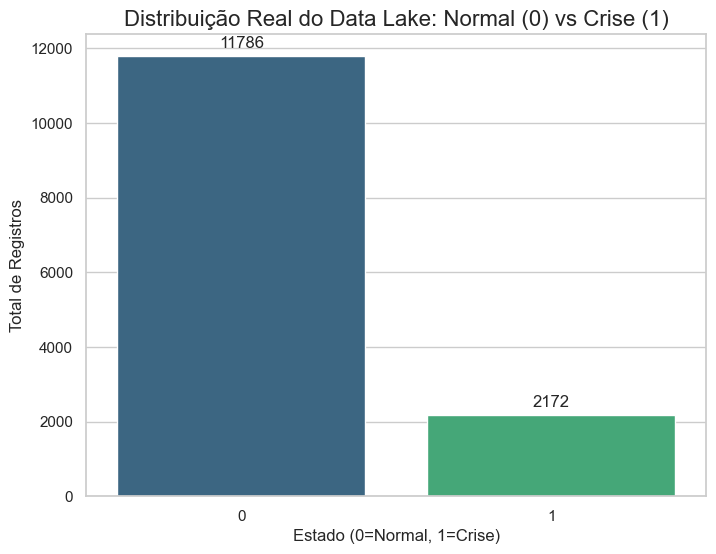

In [19]:
plt.figure(figsize=(8, 6))

# countplot com a correção de cores (hue)
ax = sns.countplot(x='crise', data=df, hue='crise', palette='viridis', legend=False)

plt.title('Distribuição Real do Data Lake: Normal (0) vs Crise (1)', fontsize=16)
plt.xlabel('Estado (0=Normal, 1=Crise)', fontsize=12)
plt.ylabel('Total de Registros', fontsize=12)

# Adiciona os números no topo das barras
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

### 3. Fronteira de Decisão (Scatterplot)
Visualizamos a relação entre **Batimentos** e **Movimento**.
* **Pontos Azuis (Normal):** Espalhados, incluindo alta movimentação (exercício).
* **Pontos Vermelhos (Crise):** Concentrados em BPM alto, mas com movimento variável (geralmente menor que exercício intenso).

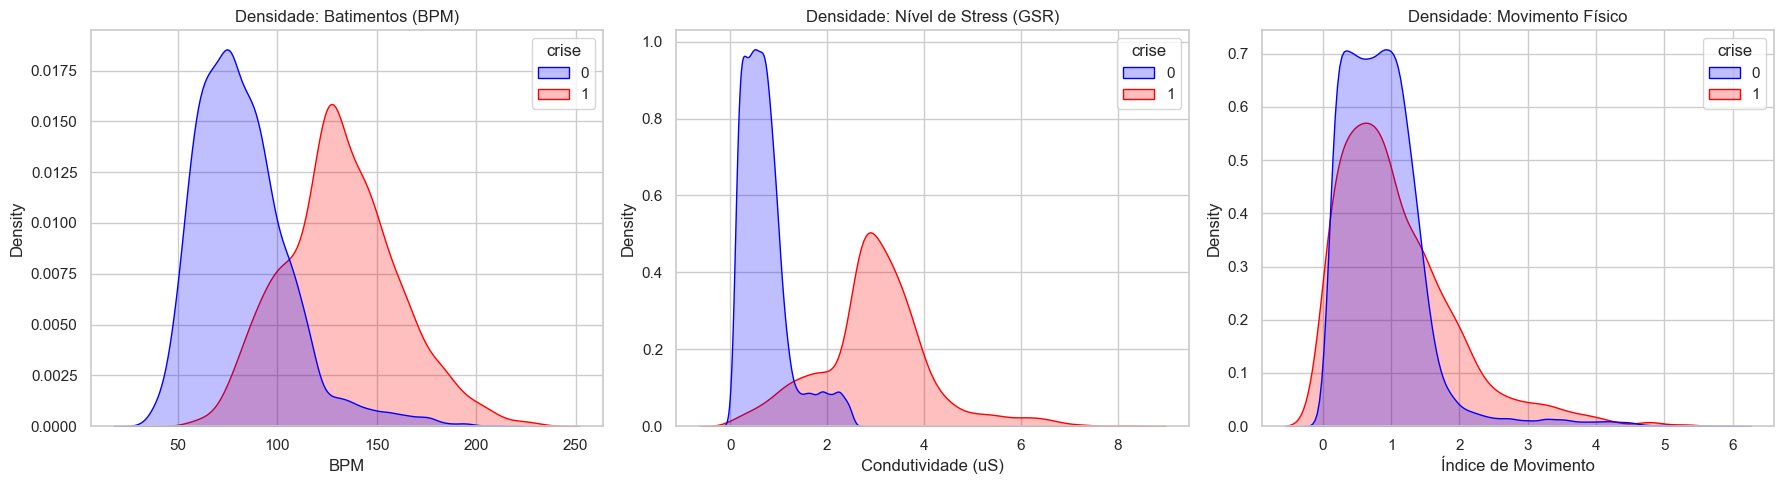

In [20]:
plt.figure(figsize=(18, 5))
cores = {0: 'blue', 1: 'red'} # Azul=Normal, Vermelho=Crise

# BPM
plt.subplot(1, 3, 1)
sns.kdeplot(data=df, x='bpm', hue='crise', palette=cores, fill=True, common_norm=False)
plt.title('Densidade: Batimentos (BPM)')
plt.xlabel('BPM')

# GSR (Suor)
plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x='gsr', hue='crise', palette=cores, fill=True, common_norm=False)
plt.title('Densidade: Nível de Stress (GSR)')
plt.xlabel('Condutividade (uS)')

# Movimento
plt.subplot(1, 3, 3)
sns.kdeplot(data=df, x='movimento', hue='crise', palette=cores, fill=True, common_norm=False)
plt.title('Densidade: Movimento Físico')
plt.xlabel('Índice de Movimento')

plt.tight_layout()
plt.show()

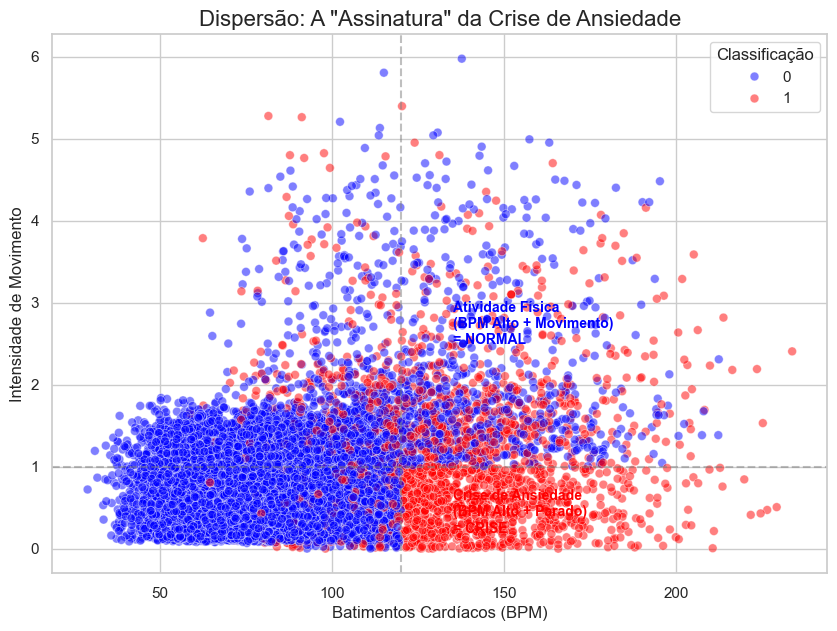

In [21]:
plt.figure(figsize=(10, 7))

# Scatterplot BPM vs Movimento
sns.scatterplot(
    x='bpm', 
    y='movimento', 
    hue='crise', 
    data=df, 
    palette=cores,
    alpha=0.5, 
    s=40
)

plt.title('Dispersão: A "Assinatura" da Crise de Ansiedade', fontsize=16)
plt.xlabel('Batimentos Cardíacos (BPM)', fontsize=12)
plt.ylabel('Intensidade de Movimento', fontsize=12)

# Linhas de corte visual
plt.axvline(x=120, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# Textos explicativos no gráfico
plt.text(135, 2.5, 'Atividade Física\n(BPM Alto + Movimento)\n= NORMAL', 
         fontsize=10, color='blue', weight='bold')

plt.text(135, 0.2, 'Crise de Ansiedade\n(BPM Alto + Parado)\n= CRISE', 
         fontsize=10, color='red', weight='bold')

plt.legend(title='Classificação')
plt.show()